# Import Dependencies

In [1]:
import torchvision
from  torchvision import models
from torchvision.transforms.v2 import Compose
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
# from torchvision.transforms import functional as F # Remove this import
import torch.nn.functional as F # Add this import
import torch
import torch.nn as nn
import os
import os
import random
from PIL import Image
import numpy as np
import os
import random

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

# Download dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lfw-dataset' dataset.
Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
!cp -r /kaggle/input/lfw-dataset /content/
print("Dataset copied to /content")

Dataset copied to /content


# Preprocess the data

In [4]:
device='cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
#apply preprocessing and data augmentation
transform=Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Create Matching Pairs

In [6]:
def create_matching_pairs_with_filtering(dataset_dir, max_pairs=10000):
    matching_pairs = []
    labels = []

    # Iterate over each folder in the dataset directory (each folder corresponds to a person)
    for person_name in os.listdir(dataset_dir):
        person_dir = os.path.join(dataset_dir, person_name)

        # Get a list of image files in the person's directory
        images = [os.path.join(person_dir, img) for img in os.listdir(person_dir) if img.endswith('.jpg')]

        # Check if the person has more than 1 image
        if len(images) > 1:
            # Create matching pairs (two images from the same person)
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    matching_pairs.append((images[i], images[j]))  # (image_1, image_2)
                    labels.append(1)  # Label 1 for matching pair

                # Stop generating if we reach the max number of pairs
                if len(matching_pairs) >= max_pairs:
                    break
        if len(matching_pairs) >= max_pairs:
            break

    return matching_pairs[:max_pairs], labels[:max_pairs]

dataset_dir = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
matching_pairs, matching_labels = create_matching_pairs_with_filtering(dataset_dir)

# Example of how to inspect the generated pairs
print(f"Generated {len(matching_pairs)} matching pairs.")


Generated 10000 matching pairs.


In [7]:
# Define the function to create non-matching pairs (balanced)
def create_non_matching_pairs_balanced(dataset_dir, num_matching_pairs, max_pairs=10000):
    non_matching_pairs = []
    non_matching_labels = []

    people = os.listdir(dataset_dir)
    num_people = len(people)

    # Generate non-matching pairs (images from different people)
    max_possible_non_matching = num_people * (num_people - 1) // 2  # Approximation, not exact image combinations
    num_to_generate = min(num_matching_pairs, max_possible_non_matching, max_pairs)

    for _ in range(num_to_generate):
        person_1_name = random.choice(people)
        person_2_name = random.choice([p for p in people if p != person_1_name])

        person_1_dir = os.path.join(dataset_dir, person_1_name)
        person_2_dir = os.path.join(dataset_dir, person_2_name)

        # Get list of images for each person
        images_1 = [os.path.join(person_1_dir, img) for img in os.listdir(person_1_dir) if img.endswith('.jpg')]
        images_2 = [os.path.join(person_2_dir, img) for img in os.listdir(person_2_dir) if img.endswith('.jpg')]

        # Only create a pair if both people have at least one image
        if images_1 and images_2:
            img_1 = random.choice(images_1)
            img_2 = random.choice(images_2)
            non_matching_pairs.append((img_1, img_2))
            non_matching_labels.append(0)

        # Stop generating if we reach the max number of pairs
        if len(non_matching_pairs) >= max_pairs:
            break

    return non_matching_pairs[:max_pairs], non_matching_labels[:max_pairs]

# Set the dataset directory path
dataset_dir = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Create the matching pairs (restrict to 10,000 pairs)
matching_pairs, matching_labels = create_matching_pairs_with_filtering(dataset_dir, max_pairs=10000)

# Create the non-matching pairs with the same number as matching pairs (restrict to 10,000 pairs)
balanced_non_matching_pairs, balanced_non_matching_labels = create_non_matching_pairs_balanced(dataset_dir, len(matching_pairs), max_pairs=10000)

# Combine the matching and non-matching pairs
all_pairs_balanced = matching_pairs + balanced_non_matching_pairs
all_labels_balanced = matching_labels + balanced_non_matching_labels

# Print the final counts
print(f"Generated {len(matching_pairs)} matching pairs and {len(balanced_non_matching_pairs)} non-matching pairs.")
print(f"Total pairs in balanced dataset: {len(all_pairs_balanced)}")


Generated 10000 matching pairs and 10000 non-matching pairs.
Total pairs in balanced dataset: 20000


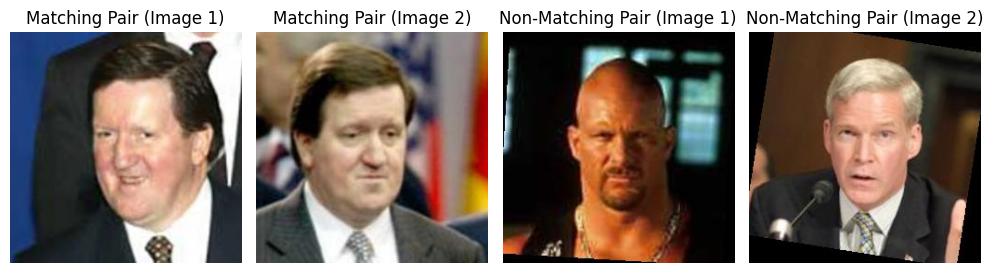

In [8]:
# Select a random matching pair
matching_indices = [i for i, label in enumerate(all_labels_balanced) if label == 1]
random_matching_index = random.choice(matching_indices)
matching_pair = all_pairs_balanced[random_matching_index]

# Select a random non-matching pair
non_matching_indices = [i for i, label in enumerate(all_labels_balanced) if label == 0]
random_non_matching_index = random.choice(non_matching_indices)
non_matching_pair = all_pairs_balanced[random_non_matching_index]

# Load and display the images
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

img1_matching = Image.open(matching_pair[0])
img2_matching = Image.open(matching_pair[1])
img1_non_matching = Image.open(non_matching_pair[0])
img2_non_matching = Image.open(non_matching_pair[1])

axes[0].imshow(img1_matching)
axes[0].set_title("Matching Pair (Image 1)")
axes[0].axis('off')

axes[1].imshow(img2_matching)
axes[1].set_title("Matching Pair (Image 2)")
axes[1].axis('off')

axes[2].imshow(img1_non_matching)
axes[2].set_title("Non-Matching Pair (Image 1)")
axes[2].axis('off')

axes[3].imshow(img2_non_matching)
axes[3].set_title("Non-Matching Pair (Image 2)")
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Create a dataset Class

In [9]:
class FacePairsDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

In [10]:
# Create the dataset instance
full_dataset = FacePairsDataset(all_pairs_balanced, all_labels_balanced, transform=transform)

# Define the split ratio (e.g., 80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 16000
Testing dataset size: 4000


In [11]:
#create a dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Architecture Design

In [12]:
# Custom Siamese Network
class Custom_Siamese_Networks(nn.Module):
    def __init__(self):
        super(Custom_Siamese_Networks, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=384 * 13 * 13, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=2)
        self.relu = nn.ReLU()

    def forward(self, x1, x2):
        # Forward pass for both input images
        x1 = self.relu(self.conv1(x1))
        x1 = self.pool1(x1)
        x1 = self.relu(self.conv2(x1))
        x1 = self.pool2(x1)
        x1 = self.relu(self.conv3(x1))
        x1 = x1.view(x1.size(0), -1)  # Flatten
        x1 = self.relu(self.fc1(x1))
        x1 = self.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = self.relu(self.conv1(x2))
        x2 = self.pool1(x2)
        x2 = self.relu(self.conv2(x2))
        x2 = self.pool2(x2)
        x2 = self.relu(self.conv3(x2))
        x2 = x2.view(x2.size(0), -1)  # Flatten
        x2 = self.relu(self.fc1(x2))
        x2 = self.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        return x1, x2


In [13]:
# Pretrained Siamese Network
class Pretrained_Siamese_Networks(nn.Module):
    def __init__(self, use_pretrained=True):
        super(Pretrained_Siamese_Networks, self).__init__()
        # Load ResNet50 pretrained model
        self.resnet = models.resnet50(pretrained=use_pretrained)
        self.fc1 = nn.Linear(in_features=2048, out_features=1024) # Changed in_features to 2048
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=2)

        # Modify the fully connected layer if fine-tuning
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer in ResNet

    def forward(self, x1, x2):
        # Forward pass for both input images
        x1 = self.resnet(x1)
        x2 = self.resnet(x2)

        # Pass through the custom fully connected layers
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)
        x1 = self.fc3(x1)

        x2 = self.fc1(x2)
        x2 = self.fc2(x2)
        x2 = self.fc3(x2)

        return x1, x2

In [14]:
# Unified Model Class to switch between Custom and Pretrained
class SiameseFaceID(nn.Module):
    def __init__(self, use_pretrained=True, use_custom_model=False):
        super(SiameseFaceID, self).__init__()

        # Choose which model to use (custom or pretrained)
        if use_custom_model:
            self.model = Custom_Siamese_Networks()
        else:
            self.model = Pretrained_Siamese_Networks(use_pretrained=use_pretrained)

    def forward(self, x1, x2):
        return self.model(x1, x2)

#Loss Function & Hyperparameter Tuning

In [15]:
def contrastive_loss(output1, output2, label, margin=1.0):
    # Calculate Euclidean distance between the two embeddings
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Contrastive loss
    loss = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                      (1 - label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))

    return loss


# Training the Model

In [16]:
# Define the training function
def train_model(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_labels = []
    total_predictions = []

    for batch_idx, (img1, img2, labels) in enumerate(train_dataloader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output1, output2 = model(img1, img2)

        # Calculate the loss
        loss = criterion(output1, output2, labels)
        running_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Collect labels and predictions
        total_labels.extend(labels.cpu().numpy())
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance < 1.0).cpu().numpy()  # Consider margin 1.0 for prediction
        total_predictions.extend(predictions)

    avg_loss = running_loss / len(train_dataloader)
    accuracy = accuracy_score(total_labels, total_predictions)
    precision = precision_score(total_labels, total_predictions)
    recall = recall_score(total_labels, total_predictions)
    f1 = f1_score(total_labels, total_predictions)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1


In [17]:
# Define the evaluation function
def evaluate_model(model, test_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_labels = []
    total_predictions = []

    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in enumerate(test_dataloader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calculate the loss
            loss = criterion(output1, output2, labels)
            running_loss += loss.item()

            # Collect labels and predictions
            total_labels.extend(labels.cpu().numpy())
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < 1.0).cpu().numpy()
            total_predictions.extend(predictions)

    avg_loss = running_loss / len(test_dataloader)
    accuracy = accuracy_score(total_labels, total_predictions)
    precision = precision_score(total_labels, total_predictions)
    recall = recall_score(total_labels, total_predictions)
    f1 = f1_score(total_labels, total_predictions)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1


In [18]:
# Set the device (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseFaceID(use_pretrained=True, use_custom_model=False).to(device)

# Define the loss function and optimizer
criterion = contrastive_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [ ]:
# Number of epochs for training
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train the model
    train_model(model, train_dataloader, optimizer, criterion, device)

    # Evaluate the model on validation data
    evaluate_model(model, test_dataloader, criterion, device)



Epoch 1/10
Training Loss: 0.2169
Accuracy: 0.6411
Precision: 0.5857
Recall: 0.9708
F1 Score: 0.7306
Validation Loss: 0.1276
Accuracy: 0.7812
Precision: 0.7016
Recall: 0.9707
F1 Score: 0.8145

Epoch 2/10
Training Loss: 0.1231
Accuracy: 0.7405
Precision: 0.6622
Recall: 0.9845
F1 Score: 0.7918
Validation Loss: 0.1008
Accuracy: 0.7628
Precision: 0.6799
Recall: 0.9833
F1 Score: 0.8040

Epoch 3/10
Training Loss: 0.1135
Accuracy: 0.7581
Precision: 0.6788
Recall: 0.9823
F1 Score: 0.8028
Validation Loss: 0.1492
Accuracy: 0.6587
Precision: 0.5925
Recall: 0.9939
F1 Score: 0.7424

Epoch 4/10
Training Loss: 0.1138
Accuracy: 0.7649
Precision: 0.6848
Recall: 0.9837
F1 Score: 0.8075
Validation Loss: 0.0899
Accuracy: 0.8170
Precision: 0.7355
Recall: 0.9838
F1 Score: 0.8418

Epoch 5/10


# Embedding Extraction